# Optimal execution
## Probabilistic permanent price impact

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"

The price process is given by

$$
    S_{t+\Delta} = S_t + \sigma\,\sqrt{\Delta}\,(2B^{a_t} - 1),
$$

* $B^{a_t} \sim \text{Blli}(\text{sigmoid}(b a_t))$
* #todo:⭐️ $B^{a_t} \vert S_{t-1} \sim \text{Blli}(\text{sigmoid}(b a_t))$

In [3]:
def price_step(key, price_old, action, b):
    p = jax.nn.sigmoid(action * b)
    jump = jax.random.bernoulli(key, p)
    jump = (2 * jump - 1)
    
    price = price_old + jump
    
    return price

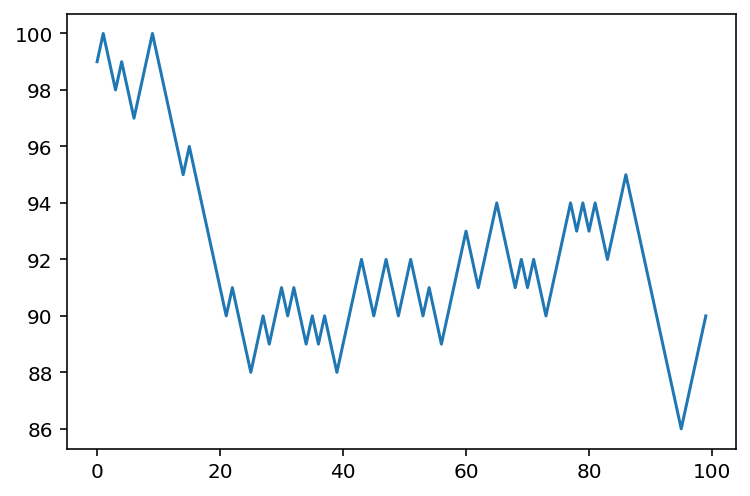

In [6]:
num_actions = 11
actions = jax.random.categorical(key_action, logits=jnp.ones(num_actions), shape=(T,)) - 5

state = (keys_price, actions)
_, price_hist = jax.lax.scan(price_step_scan, price_init, state)

plt.plot(price_hist)

In [7]:
actions

DeviceArray([ 2,  2, -5, -2,  3, -5, -2,  4,  4, -4, -4,  1,  0, -1, -4,
              5, -4, -3, -4, -4, -1,  0, -3, -4, -3,  3,  3,  2, -2, -1,
              1, -2,  4,  0,  1, -3, -2, -5, -4, -3,  5,  4,  3, -2,  0,
             -2, -5,  5, -3, -1,  4, -2,  5,  5,  5,  0, -3, -1, -2,  1,
             -1,  3,  2,  4,  3, -2, -5,  5, -3,  1, -1,  5, -3,  3,  4,
              1,  4,  4, -4,  4,  3,  5,  0, -1,  4,  3,  0,  4, -5, -5,
              3,  0,  5, -2,  5,  3, -1,  0,  4,  1], dtype=int32)

In [10]:
def sample_path(key, price_init, T, b):
    num_actions = 11
    key_action, keys_price = jax.random.split(key, 2)
    keys_price = jax.random.split(keys_price, T)

    actions = jax.random.categorical(key_action, logits=jnp.ones(num_actions), shape=(T,)) - 5
    state = (keys_price, actions)
    _, price_hist = jax.lax.scan(price_step_scan, price_init, state)
    
    return price_hist

sample_paths = jax.vmap(sample_path, in_axes=(0, None, None, None))

In [11]:
num_paths = 100
keys = jax.random.split(key, num_paths)

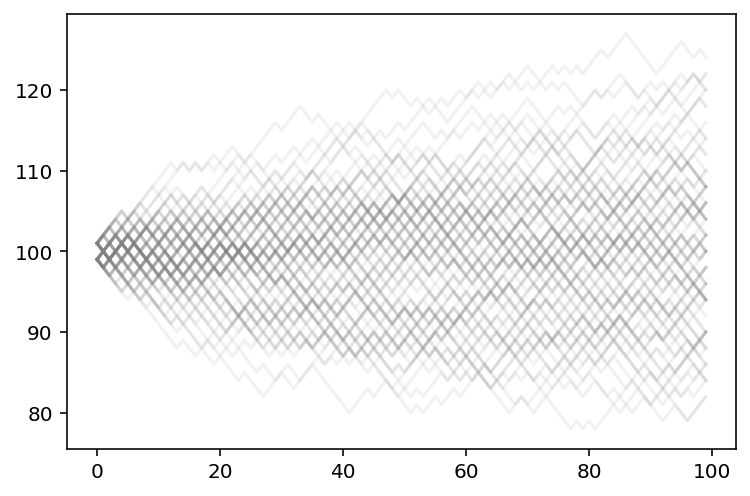

In [12]:
b = 0
plt.plot(sample_paths(keys, price_init, T, b).T, c="tab:gray", alpha=0.1);

## State-space
* Price: $(2N_T + 1)$
* Inventory $[-\tilde q, \tilde q]$ (because we want)
* Time: $[0, N_T]$

## Action-state
* Actions -> $a_1, a_2, \ldots, a_K\$

In [111]:
class PriceProcess:
    def __init__(self, init_state, alpha, kappa,  sigma, delta, b, policy, actions, prices, inventories):
        """
        Parameters
        ----------
        init_state: Array(3)
            Price, inventory_init, time_init
        sigma: float
            Volatility
        delta: float
            Time discretisation
        b: float
            Price impact factor
        policy: Array(2T + 1, q_max - q_min + 1, T)
            ...
        """
        self.init_state = init_state
        self.alpha = alpha
        self.kappa = kappa
        self.sigma = sigma
        self.delta = delta
        self.b = b
        self.policy = policy # We may not need this one.
        self.actions = actions
        self.num_actions = len(actions)
        self.prices = prices
        self.inventories = inventories        
        self.price_cardinality, self.inventory_size, self.number_timesteps = policy.shape
        self.times = jnp.arange(0, self.delta * self.number_timesteps, self.delta)

    def episode_step(self, key, state_old):
        # Refactor: redefine the policy as a parameter of the function
        price_old, inventory_old, time_old = state_old
        
        index_p_old = jnp.argmin((price_old - self.prices) ** 2)
        index_t_old = jnp.argmin((time_old - self.times) ** 2)
        index_i_old = jnp.argmin((inventory_old - self.inventories) ** 2)
        
        # FIX -- reafactor into function
        action = policy[index_p_old, index_i_old, index_t_old]
        inventory_new = jnp.clip(action+inventory_old, jnp.min(self.inventories), jnp.max(self.inventories))
        action = inventory_new - inventory_old
        
        time_new = time_old + self.delta       
        p = jax.nn.sigmoid(action * self.b)
        jump = jax.random.bernoulli(key, p)
        jump = self.sigma * jnp.sqrt(self.delta) * (2 * jump - 1)
        price = price_old + jump
        state = jnp.array([price, inventory_new, time_new])
        return state, price
    
    def episode_and_reward_step(self, key, state_old):
        state_new, _ = episode_step(key, state_old)
        _, inventory_old, _ = state_old
        _, inventory_new, _ = state_new
        action = inventory_new - inventory_old
        reward = reward_step(action, state_old, state_new)
        return reward, state_new
    
    def reward_step(action, state_old, state_new):
        price_old, inventory_old, time_old = state_old
        price_new, inventory_new, time_new = state_new
        reward = (time_new>=T)*(self.alpha * inventory_new**2) + (-self.kappa*action**2 -inventory_new*(action*(price_old+self.kappa*action)) )
        return reward
    
    def price_step(self, key, state_old):
        price_old, inventory_old, time_old = state_old
        
        index_p_old = jnp.argmin((price_old - self.prices) ** 2)
        index_t_old = jnp.argmin((time_old - self.times) ** 2)
        index_i_old = jnp.argmin((inventory_old - self.inventories) ** 2)
        
        # FIX -- reafactor into function
        action = self.policy[index_p_old, index_i_old, index_t_old]
        inventory_new = jnp.clip(action+inventory_old, jnp.min(self.inventories), jnp.max(self.inventories))
        action = inventory_new - inventory_old
        p = jax.nn.sigmoid(action * self.b)
        jump = jax.random.bernoulli(key, p)
        jump = self.sigma * jnp.sqrt(self.delta) * (2 * jump - 1)
        price = price_old + jump
        return price

    def price_step_scan(self, state, key):
        #price = self.price_step(key, state)
        state, price = self.state_step(key, state)
        return state, price
    
    def sample_path(self, key):
        price_init, *_ = self.init_state
        key_action, keys_price = jax.random.split(key, 2)
        keys_price = jax.random.split(keys_price, self.number_timesteps)
        _, price_hist = jax.lax.scan(self.price_step_scan, self.init_state, keys_price)

        return price_hist
    
    def sample_paths(self, key, num_paths):
        keys = jax.random.split(key, num_paths)
        vmap_fn = jax.vmap(self.sample_path, in_axes=(0))
        return vmap_fn(keys)

    
    def episode_path(self, key):
        price_init, *_ = self.init_state
        key_action, keys_price = jax.random.split(key, 2)
        keys_price = jax.random.split(keys_price, self.number_timesteps)
        _, price_hist = jax.lax.scan(self.price_step_scan, self.init_state, keys_price)

        return price_hist    

        
    def update_policy(self):
        ...

In [112]:
buy_min = -5
buy_max = 5

T = 100
inventory_size_min = -100
inventory_size_max = 100

policy_space = (2 * T + 1, # Size of price grid
                inventory_size_max - inventory_size_min + 1, # Size of inventory grid
                T, # time-steps
                buy_max - buy_min + 1) # number of actions
state_space = policy_space[:-1]


returns = jnp.zeros(policy_space)
counts = jnp.ones(policy_space)
Q = returns / counts

policy = jnp.zeros(state_space)

b = 0.01
sigma = 1.0
delta = 1.0
alpha = 0.1
kappa = 0.001
init_state = jnp.array([100., 10, 0])
actions = jnp.arange(buy_min, buy_max + 1)
prices = jnp.arange(-100, 100)*sigma*jnp.sqrt(delta) + 100.
inventories = jnp.arange(inventory_size_min, inventory_size_min+1)



price_process = PriceProcess(init_state, alpha, kappa, sigma, delta, b, policy, actions, prices, inventories)

price_process.sample_path(key)

DeviceArray([ 99., 100.,  99.,  98.,  99.,  98.,  97.,  96.,  97.,  98.,
              97.,  96.,  95.,  94.,  93.,  94.,  93.,  92.,  93.,  94.,
              93.,  92.,  93.,  92.,  91.,  90.,  91.,  92.,  91.,  92.,
              93.,  92.,  93.,  92.,  91.,  92.,  91.,  92.,  91.,  90.,
              91.,  92.,  93.,  94.,  93.,  92.,  93.,  92.,  91.,  90.,
              91.,  92.,  91.,  90.,  89.,  88.,  87.,  88.,  89.,  90.,
              91.,  90.,  89.,  90.,  91.,  92.,  91.,  90.,  91.,  92.,
              91.,  92.,  91.,  90.,  89.,  90.,  91.,  92.,  91.,  92.,
              91.,  92.,  91.,  90.,  91.,  92.,  93.,  92.,  91.,  90.,
              89.,  88.,  87.,  86.,  85.,  84.,  85.,  86.,  87.,  88.],            dtype=float32)

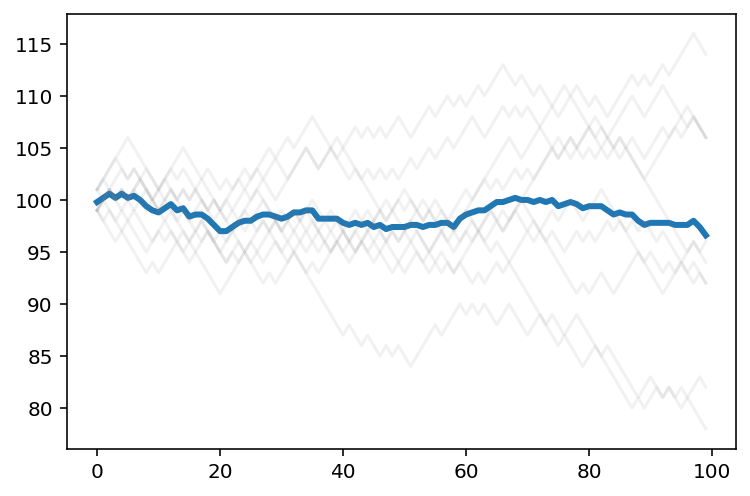

In [113]:
num_paths = 10
paths = price_process.sample_paths(key, num_paths)
plt.plot(paths.mean(axis=0), linewidth=3)
plt.plot(paths.T, c="tab:gray", alpha=0.1);

In [113]:
price_ix_to_value = {i: v for i,v in enumerate(range(-T, T + 1))}
inventory_ix_to_value = {i: v for i,v in enumerate(range(inventory_size_min, inventory_size_max + 1))}

price_value_to_ix = {v: i for i,v in price_ix_to_value.items()}
inventory_value_to_ix = {v: i for i,v in inventory_ix_to_value.items()}

In [ ]:
def price_ix_to_value(ix):
    

In [148]:
def price_step(key, price_old, action, b):
    p = jax.nn.sigmoid(action * b)
    jump = jax.random.bernoulli(key, p)
    jump = (2 * jump - 1)
    
    price = price_old + jump
    
    return price

def episode_step(key, state_old, policy, b):
    price_ix, inventory_ix, time = state_old
    action = policy[state_old]
    
    # to-do: clean 🤮🤮
    price = price_ix + 
    inventory = inventory_ix_to_value[inventory_ix]
    
    new_inventory = jnp.clip(inventory + action, inventory_size_min, inventory_size_max)
    new_action = new_inventory - inventory
    new_price = price_step(key, price, new_action, b)
    new_time = time + 1
    
    
    values_new = {
        "price": new_price,
        "inventory": new_inventory,
        "time": new_time
    }
    
    state_new = [
        price_value_to_ix[new_price],
        inventory_value_to_ix[new_inventory],
        new_time
    ]
    
    return state_new, values_new

In [149]:
key = jax.random.PRNGKey(271)
key_price, key_inventory, key_action, keys_steps = jax.random.split(key, 4)
keys_steps = jax.random.split(keys_steps, T)

values_init = jnp.stack([
    jax.random.randint(key_price, (1,), -T, T),
    jax.random.randint(key_inventory, (1,), inventory_size_min, inventory_size_max),
    jnp.array([0]),
]).ravel()

action_init = jax.random.randint(key_action, (1,), buy_min, buy_max)

state_init = jnp.array([
    price_value_to_ix[values_init[0].item()],
    inventory_value_to_ix[values_init[1].item()],
    values_init[2]
])

state_init

DeviceArray([108,  12,   0], dtype=int32)

### Tod

In [ ]:
def episode_vmap_step(state_old, key):
    episode_step(key, state_old, policy, b)
    
jax.lax.scan(episode_vmap_step, state_init, keys_steps, )